In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import h5py

In [2]:
def load_data():
    # Veriyi CSV formatından yükle
    df = pd.read_csv('XRP_normalized.csv', parse_dates=['Date'])

    # Eksik değerleri kontrol et ve temizle
    print("Eksik değer sayısı:", df.isnull().sum().sum())
    df = df.dropna(subset=['Price'])

    # Tarihe göre sırala
    df = df.sort_values('Date')

    # Sadece 'Price' sütununu kullan
    prices = df[['Date', 'Price']].set_index('Date')
    return prices

# Veri setini yükle
data = load_data()

Eksik değer sayısı: 0


In [7]:
# Veriyi ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Zaman serisi verilerini LSTM için hazırlama
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parametreler
SEQ_LENGTH = 60  # 3 aylık geçmiş veri
TEST_SIZE = 0.3  #%30 test verisi

# Veriyi dizilere dönüştür
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Eğitim-test bölümlemesi
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [8]:
# LSTM modelini oluşturma
model = Sequential([
    LSTM(115, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(90, return_sequences=False),
    Dropout(0.23),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Erken durdurma
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğitme
history = model.fit(
    X_train, y_train,
    epochs=32,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Save the model
#model.save('lstm_model.h5')

# Eğitim geçmişini kaydetme
#joblib.dump(history.history, 'history.pkl')

# Tahmin yapma
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevirme
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test)

# Metrikleri hesaplama fonksiyonu
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    # Adjusted R2 hesaplama
    n = len(actual)
    p = 1  # Bağımsız değişken sayısı
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Adjusted R2': adj_r2
    }

# Eğitim ve test metrikleri
train_metrics = calculate_metrics(y_train_actual, train_predict)
test_metrics = calculate_metrics(y_test_actual, test_predict)

print("\nEğitim Seti Metrikleri:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Seti Metrikleri:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 2/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4241e-04 - val_loss: 0.0011
Epoch 3/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1208e-04 - val_loss: 0.0022
Epoch 4/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7493e-04 - val_loss: 0.0016
Epoch 5/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1378e-04 - val_loss: 0.0018
Epoch 6/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3200e-04 - val_loss: 0.0023
Epoch 7/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8930e-04 - val_loss: 7.2989e-04
Epoch 8/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2124e-04 - val_loss: 6.4641e-04
Epoch 9/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3914e-04 - val_loss: 9.4463e-04
Epoch 10/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3443e-04 - val_loss: 0.0016
Epoch 11/32
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8091e-04 - val_loss: 5.7811e-04
Epoch 1

In [ ]:
# Grafikleri çizme
plt.figure(figsize=(15, 12))

# Gerçek vs Tahmin scatter plot
plt.subplot(2, 2, 1)
plt.scatter(y_test_actual, test_predict, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Gerçek vs Tahmin Değerleri (Test Seti)')
plt.grid(True)

# Hata dağılımı histogramı
plt.subplot(2, 2, 2)
errors = y_test_actual.flatten() - test_predict.flatten()
sns.histplot(errors, kde=True)
plt.xlabel('Tahmin Hataları')
plt.ylabel('Frekans')
plt.title('Tahmin Hatalarının Dağılımı')
plt.grid(True)

# Kayıp eğrisi
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.title('Model Kaybının Gelişimi')
plt.legend()
plt.grid(True)

# Gerçek vs Tahmin zaman serisi
plt.subplot(2, 2, 4)
test_dates = data.index[split_idx + SEQ_LENGTH:]
plt.plot(test_dates, y_test_actual, label='Gerçek Değerler')
plt.plot(test_dates, test_predict, label='Tahminler', alpha=0.7)
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('Zaman Serisi Üzerinde Gerçek vs Tahmin')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import h5py
from datetime import datetime, timedelta
# Veriyi yükleme ve önişleme
def load_data():
    # Veriyi CSV formatından yükle
    df = pd.read_csv('XRP_normalized.csv', parse_dates=['Date'])

    # Eksik değerleri kontrol et ve temizle
    print("Eksik değer sayısı:", df.isnull().sum().sum())
    df = df.dropna(subset=['Price'])

    # Tarihe göre sırala
    df = df.sort_values('Date')

    # Sadece 'Price' sütununu kullan
    prices = df[['Date', 'Price']].set_index('Date')
    return prices

# Veri setini yükle
data = load_data()

# Veriyi ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Zaman serisi verilerini LSTM için hazırlama
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parametreler
SEQ_LENGTH = 60  # 3 aylık geçmiş veri
TEST_SIZE = 0.2  #%30 test verisi

# Veriyi dizilere dönüştür
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Eğitim-test bölümlemesi
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# LSTM modelini oluşturma
model = Sequential([
    LSTM(144, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.24),
    LSTM(72, return_sequences=True),
    Dropout(0.24),
    LSTM(36,return_sequences=False)
    Dropout(0.24)
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Erken durdurma
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğitme
history = model.fit(
    X_train, y_train,
    epochs=32,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Save the model
#model.save('XRP_lstm_model2.h5')

# Eğitim geçmişini kaydetme
#joblib.dump(history.history, 'XRP_history2.pkl')

# Tahmin yapma
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevirme
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test)

# Metrikleri hesaplama fonksiyonu
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    # Adjusted R2 hesaplama
    n = len(actual)
    p = 1  # Bağımsız değişken sayısı
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Adjusted R2': adj_r2
    }

# Eğitim ve test metrikleri
train_metrics = calculate_metrics(y_train_actual, train_predict)
test_metrics = calculate_metrics(y_test_actual, test_predict)

print("\nEğitim Seti Metrikleri:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Seti Metrikleri:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")



# # Gelecek bir ayın tahminlerini yapma
# future_predictions = []
# current_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
# for _ in range(30):
#     next_pred_scaled = model.predict(current_sequence)
#     next_pred = scaler.inverse_transform(next_pred_scaled)
#     future_predictions.append(next_pred[0, 0])
#     next_pred_scaled_reshaped = next_pred_scaled.reshape(1, 1, 1)
#     current_sequence = np.append(current_sequence[:, 1:, :], next_pred_scaled_reshaped, axis=1)

# # Gelecek tarihleri oluşturma
# last_date = data.index[-1]
# future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# # Tahminleri DataFrame'e çevirme
# future_df = pd.DataFrame({'Date': future_dates, 'Price': future_predictions})

# # Son 180 gün ve gelecek tahminlerin grafiğini çizme
# last_180_days = data.iloc[-180:]
# plt.figure(figsize=(12, 6))
# plt.plot(last_180_days.index, last_180_days['Price'], label='Geçmiş Veriler')
# plt.plot(future_df['Date'], future_df['Price'], label='Gelecek Tahminler', color='red')
# plt.xlabel('Tarih')
# plt.ylabel('Fiyat')
# plt.title('XRP Fiyatı: Gelecek Bir Ay Tahmini')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.show()


# Varsayım: scaled_data, model, scaler ve SEQ_LENGTH zaten tanımlı
# future_dates da pd.date_range ile oluşturulmuş bir liste olsun
# future_dates = pd.date_range(start='2023-10-01', periods=30, freq='D')  # Örnek tarihler

# # Gelecek bir ayın tahminlerini yapma ve listede tutma
# future_predictions = []
# current_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
# for i in range(30):
#     next_pred_scaled = model.predict(current_sequence)
#     next_pred = scaler.inverse_transform(next_pred_scaled)
#     future_predictions.append((future_dates[i], next_pred[0, 0]))
#     next_pred_scaled_reshaped = next_pred_scaled.reshape(1, 1, 1)
#     current_sequence = np.append(current_sequence[:, 1:, :], next_pred_scaled_reshaped, axis=1)

# # Tahminleri DataFrame'e çevirme
# future_df = pd.DataFrame(future_predictions, columns=['Date', 'Price'])

# # Tahminleri CSV dosyasına kaydetme
# future_df.to_csv('future_predictions.csv', index=False)

# # Grafik çizimi (örnek geçmiş veri ile)
# # Varsayım: data adında bir DataFrame geçmiş verileri içeriyor
# last_180_days = data.iloc[-180:]
# plt.figure(figsize=(12, 6))
# plt.plot(last_180_days.index, last_180_days['Price'], label='Geçmiş Veriler')
# plt.plot(future_df['Date'], future_df['Price'], label='Gelecek Tahminler', color='red')
# plt.xlabel('Tarih')
# plt.ylabel('Fiyat')
# plt.title('XRP Fiyatı: Gelecek Bir Ay Tahmini')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.show()

# Bugünün tarihini al
# today = datetime.today()

# # Gelecek 30 günün tarihlerini oluştur
# future_dates = [today + timedelta(days=i) for i in range(30)]

# # Gelecek bir ayın tahminlerini yapma ve listede tutma
# future_predictions = []
# current_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)  # scaled_data: ölçeklendirilmiş son veriler
# for i in range(30):
#     next_pred_scaled = model.predict(current_sequence)  # model: önceden eğitilmiş tahmin modeli
#     next_pred = scaler.inverse_transform(next_pred_scaled)  # scaler: veriyi ölçeklendiren araç
#     future_predictions.append((future_dates[i], next_pred[0, 0]))
#     next_pred_scaled_reshaped = next_pred_scaled.reshape(1, 1, 1)
#     current_sequence = np.append(current_sequence[:, 1:, :], next_pred_scaled_reshaped, axis=1)

# # Tahminleri DataFrame'e çevirme
# future_df = pd.DataFrame(future_predictions, columns=['Date', 'Price'])
# future_df['Date'] = future_df['Date'].dt.strftime('%Y-%m-%d')

# # Tahminleri CSV dosyasına kaydetme
# future_df.to_csv('future_predictions.csv', index=False)

# # Grafik çizimi (örnek geçmiş veri ile)
# last_180_days = data.iloc[-180:]  # data: geçmiş verileri içeren DataFrame
# plt.figure(figsize=(12, 6))
# plt.plot(last_180_days.index, last_180_days['Price'], label='Geçmiş Veriler')
# plt.plot(future_df['Date'], future_df['Price'], label='Gelecek Tahminler', color='red')
# plt.xlabel('Tarih')
# plt.ylabel('Fiyat')
# plt.title('XRP Fiyatı: Gelecek Bir Ay Tahmini')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.show()

Eksik değer sayısı: 0
Epoch 1/32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 2/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.7659e-04 - val_loss: 0.0012
Epoch 3/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1532e-04 - val_loss: 0.0015
Epoch 4/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1969e-04 - val_loss: 8.3615e-04
Epoch 5/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0315e-04 - val_loss: 0.0012
Epoch 6/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7963e-04 - val_loss: 0.0043
Epoch 7/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2939e-04 - val_loss: 0.0019
Epoch 8/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0518e-04 - val_loss: 7.3010e-04
Epoch 9/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.2443e-04 - val_loss: 7.4224e-04
Epoch 10/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.3292e-04 - val_loss: 7.7824e-04
Epoch 11/32
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4023e-04 - val_loss: 7.3374e-04
Epoch 12/32
94

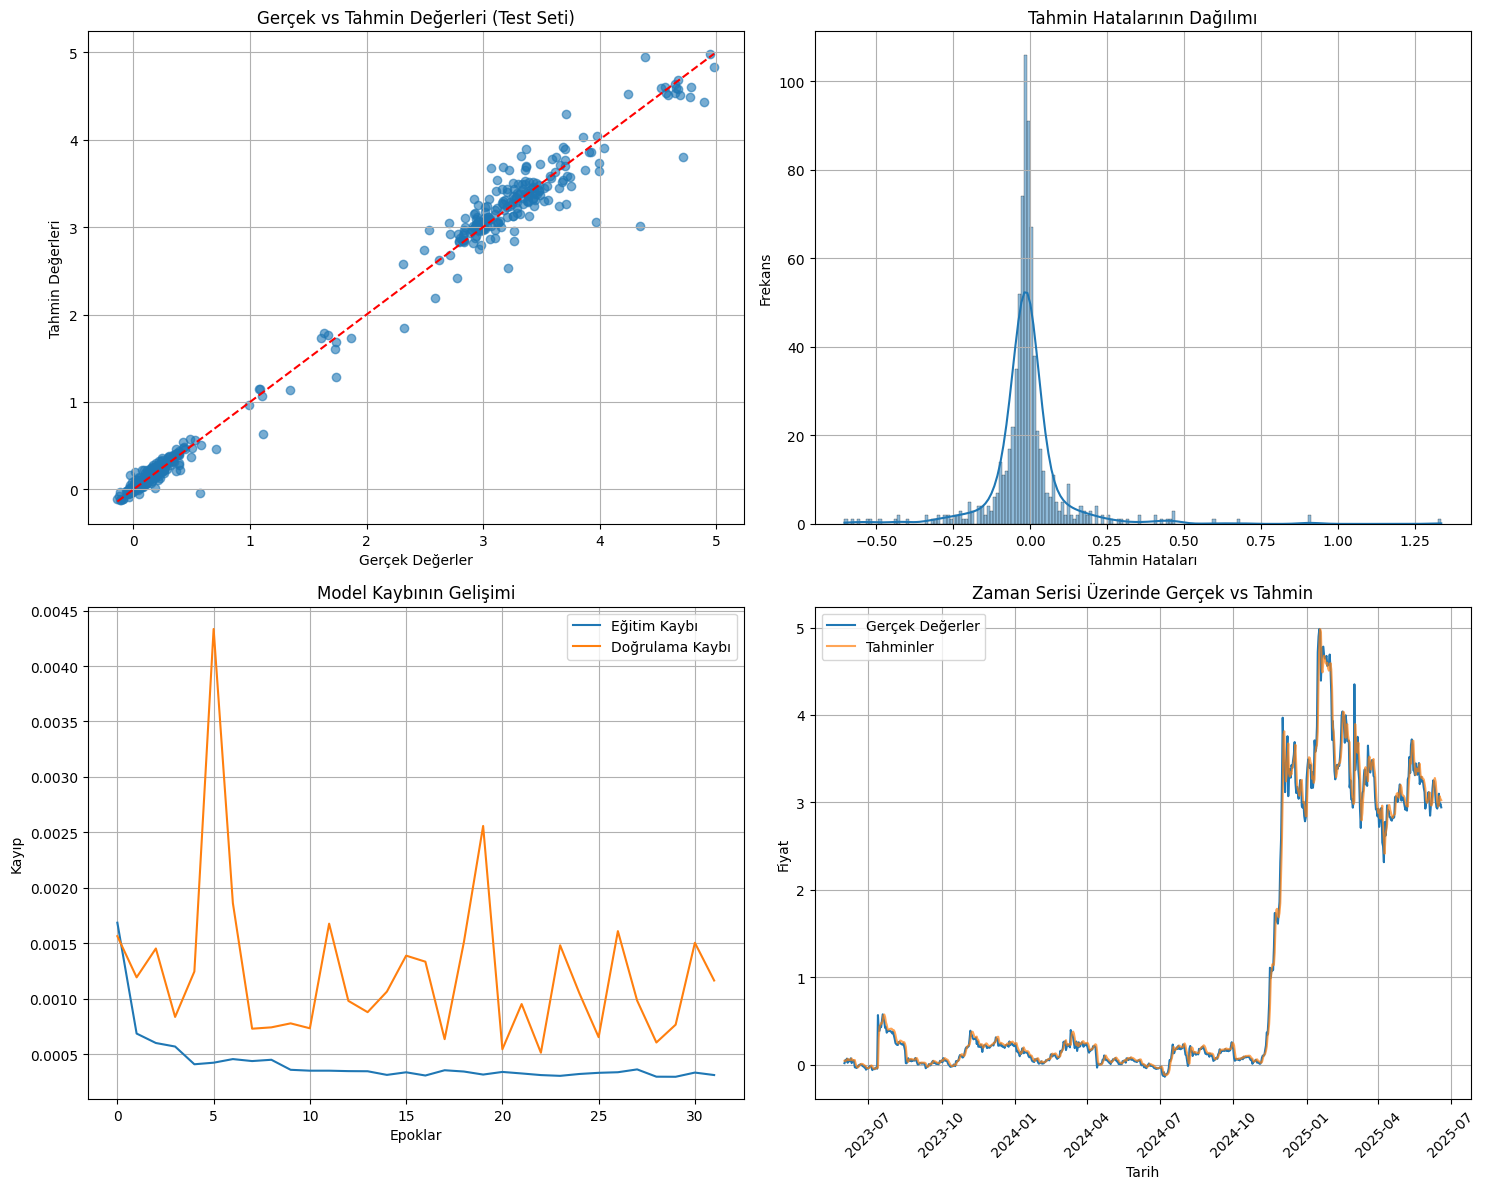

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

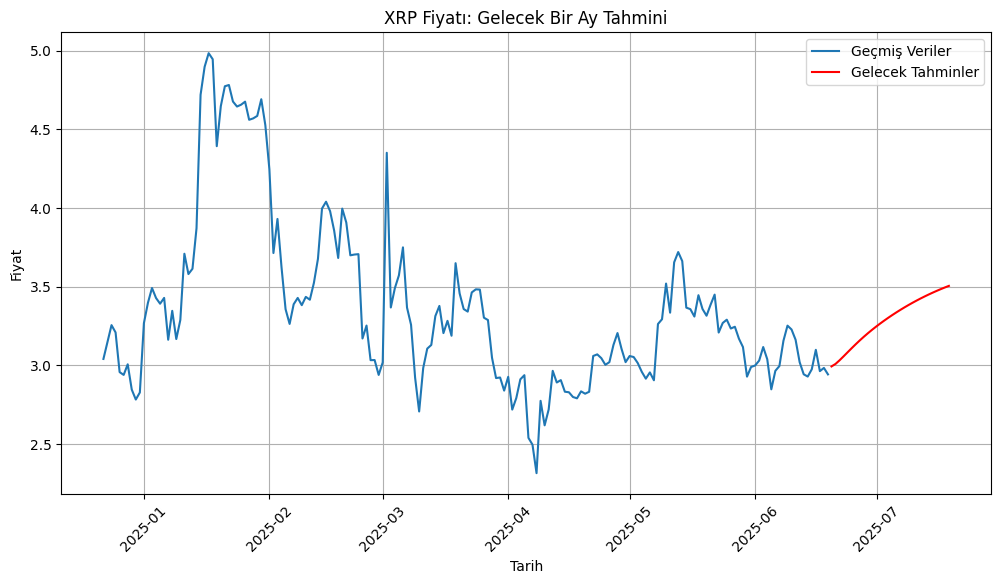

In [14]:

from datetime import datetime, timedelta
# Grafikleri çizme
plt.figure(figsize=(15, 12))

# Gerçek vs Tahmin scatter plot
plt.subplot(2, 2, 1)
plt.scatter(y_test_actual, test_predict, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Gerçek vs Tahmin Değerleri (Test Seti)')
plt.grid(True)

# Hata dağılımı histogramı
plt.subplot(2, 2, 2)
errors = y_test_actual.flatten() - test_predict.flatten()
sns.histplot(errors, kde=True)
plt.xlabel('Tahmin Hataları')
plt.ylabel('Frekans')
plt.title('Tahmin Hatalarının Dağılımı')
plt.grid(True)

# Kayıp eğrisi
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.title('Model Kaybının Gelişimi')
plt.legend()
plt.grid(True)

# Gerçek vs Tahmin zaman serisi
plt.subplot(2, 2, 4)
test_dates = data.index[split_idx + SEQ_LENGTH:]
plt.plot(test_dates, y_test_actual, label='Gerçek Değerler')
plt.plot(test_dates, test_predict, label='Tahminler', alpha=0.7)
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('Zaman Serisi Üzerinde Gerçek vs Tahmin')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

today = datetime.today()

# Gelecek 30 günün tarihlerini oluştur
future_dates = [today + timedelta(days=i) for i in range(30)]

# Gelecek bir ayın tahminlerini yapma ve listede tutma
future_predictions = []
current_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)  # scaled_data: ölçeklendirilmiş son veriler
for i in range(30):
    next_pred_scaled = model.predict(current_sequence)  # model: önceden eğitilmiş tahmin modeli
    next_pred = scaler.inverse_transform(next_pred_scaled)  # scaler: veriyi ölçeklendiren araç
    future_predictions.append((future_dates[i], next_pred[0, 0]))
    next_pred_scaled_reshaped = next_pred_scaled.reshape(1, 1, 1)
    current_sequence = np.append(current_sequence[:, 1:, :], next_pred_scaled_reshaped, axis=1)

# Tahminleri DataFrame'e çevirme
future_df = pd.DataFrame(future_predictions, columns=['Date', 'Price'])
# future_df['Date'] = future_df['Date'].dt.strftime('%Y-%m-%d') # Bu satırı kaldırın

# Tahminleri CSV dosyasına kaydetme
future_df.to_csv('future_predictions.csv', index=False)

# Grafik çizimi (örnek geçmiş veri ile)
last_180_days = data.iloc[-180:]  # data: geçmiş verileri içeren DataFrame
plt.figure(figsize=(12, 6))
plt.plot(last_180_days.index, last_180_days['Price'], label='Geçmiş Veriler')
# future_df['Date'] already contains datetime objects, which Matplotlib can plot
plt.plot(future_df['Date'], future_df['Price'], label='Gelecek Tahminler', color='red')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('XRP Fiyatı: Gelecek Bir Ay Tahmini')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
